# Laplacian Associative Memory (LAM)

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

In [1618]:
import numpy as np
import matplotlib.pyplot as plt

In [1619]:
# np.random.seed(123)

In [1620]:
# Weight Update:
# w[ij] = w_E[ij] - (max(alpha) - alpha) * w_L[ij] - (1 + alpha) * w_G[ij]

# Excitatory Weights:
# w_E[ij] = (1/NV) * sum(memory.T * memory) * (max(alpha) * kronecker_delta + heteroassociative_matrix) * z[i] * z[j]

# Local Inhibition Weights:
# w_L[ij] = (1/NV) * sum(memory.T) * z[i] * z[j]

# Global Inhibition Weights:
# w_G[ij] = (P/NV) * ((1/P) * sum(memory.T) * z[i]) * ((1/P) * sum(memory) * z[j]) + ((1/N) * gamma)

# P = Number of memories
# N = Number of neurons
# alpha = Auto-associative strength (+/- | Negative auto-association)
# eigenvalue = # Global inhibitory strength


In [1621]:
class LAM():
    def __init__(self, n_dim, n_memory, alpha, eigenvalue):
        self.N = n_dim
        self.P = n_memory
        self.a = alpha

        self.λ = eigenvalue
        self.v = None

        self.weights = np.zeros((self.N, self.N))

        self.w_E = np.zeros_like(self.weights) # Excitation
        self.w_L = np.zeros_like(self.weights) # Local inhibition

        self.w_Gμ = np.zeros_like(self.weights) # μ empty matrix
        self.w_Gv = np.zeros_like(self.weights) # v empty matrix
        self.w_G = np.zeros_like(self.weights) # Global inhibition

        self.degree = np.zeros_like(self.weights)
        self.adjacency = np.zeros_like(self.weights)
        self.laplacian = np.zeros_like(self.weights)

    def train(self, data):
        for sample in data:
            memory = np.array([sample])

            # Sum local inhibition
            self.w_L += memory * memory.T # Outer product

            # Sum global inhibition
            self.w_Gμ += memory
            self.w_Gv += memory.T

        # Normalise w_L
        self.w_L /= self.P # Normalise w_L - (1/N)
        np.fill_diagonal(self.w_L, 0) # Set the w_L diagonal to zero

        # Construct Global inhibition
        self.w_Gμ *= (1/self.P)
        self.w_Gv *= (1/self.P)
        self.w_G = (self.P / self.N) * np.dot(self.w_Gμ, self.w_Gv) + (1/self.N) * self.λ

        # Construct laplacian matrix (w_L)
        self.degree = np.diag(np.sum(self.w_L, axis=1)) # Degree of each vertex
        self.adjacency[np.abs(self.w_L) > 0] = 1 # Normalized connectivity of network
        np.fill_diagonal(self.adjacency, 0) # Set diagonal to 0
        self.laplacian = self.degree - self.adjacency # Construct laplacian matrix (simple | L = D - A)

    def infer(self, state, units):
        idx = np.random.randint(0, self.N, size=units) # Index units
        spin = np.dot(self.w_L[idx,:], state) # Weighted sum
        state[idx] = self.step(spin) # Threshold activation
        return state

    def step(self, x): # Heaviside step function
        return np.where(x > 0, 1, -1)

    def compute_energy(self, state): # As per original paper
        return -0.5 * np.dot(np.dot(self.w_L, state), state.T)
    
    def kronecker_delta(i, j):
        return 1 if i==j else 0

In [1622]:
n_dim = 64
n_memory = 8
p = 0.5

alpha = 0.1
eigenvalue = 0.5

In [1623]:
data = np.random.choice([-1, 1], size=n_dim*n_memory, p=[p, 1-p]) # Binary dipole (+/-) input with sparsity
data = data.reshape(n_memory, n_dim)

print(data.shape)

(8, 64)


In [1624]:
# Build model
model = LAM(n_dim, n_memory, alpha, eigenvalue)

In [1625]:
# Summary
w = int((n_dim * (n_dim - 1)) / 2)

print(n_dim, "neurons")
print(w, "weighted connections")
print(f"{n_dim * 0.138:.2f} point attactors")
print(f"{0.24 * w:.2f} bit capacity")

64 neurons
2016 weighted connections
8.83 point attactors
483.84 bit capacity


In [1626]:
# Train (Encoding)
model.train(data)

Text(0.5, 1.0, 'Laplacian')

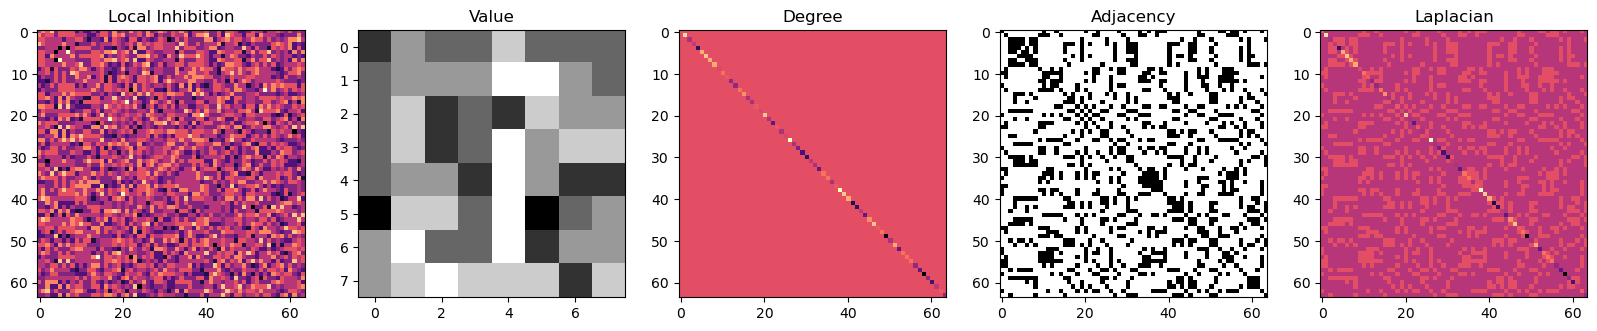

In [1627]:
plt.figure(figsize=(20,60))
plt.subplot(1,5,1)
plt.imshow(model.w_L, cmap='magma')
plt.title("Local Inhibition")

plt.subplot(1,5,2)
plt.imshow(model.w_L[1].reshape(int(n_dim**0.5),int(n_dim**0.5)), cmap='binary')
plt.title("Value")

plt.subplot(1,5,3)
plt.imshow(model.degree, cmap='magma')
plt.title("Degree")

plt.subplot(1,5,4)
plt.imshow(model.adjacency, cmap='gray')
plt.title("Adjacency")

plt.subplot(1,5,5)
plt.imshow(model.laplacian, cmap='magma')
plt.title("Laplacian")

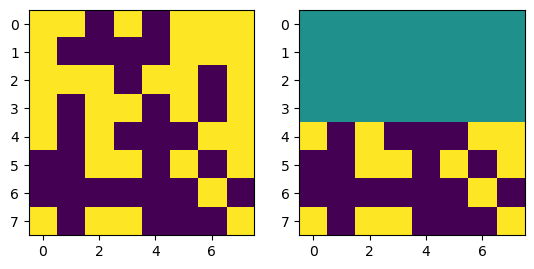

In [1628]:
state = np.copy(data[0])
state[:int(n_dim/2)] = 0 # Mask
# state += np.random.randint(-1,2,(ndim)) # Noise

plt.subplot(1,2,1)
plt.imshow(data[0].reshape(int(n_dim**0.5),int(n_dim**0.5)))
plt.subplot(1,2,2)
plt.imshow(state.reshape(int(n_dim**0.5),int(n_dim**0.5)))

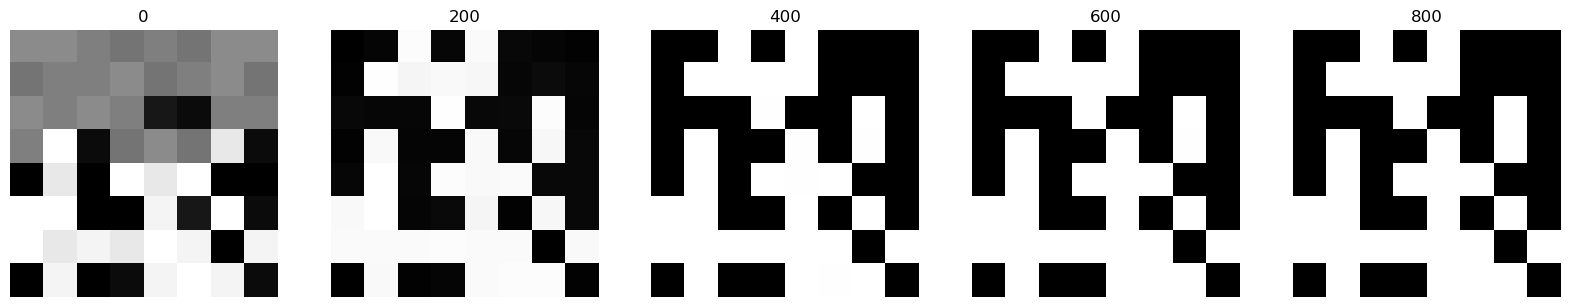

In [1629]:
# Infer (Retrieval)
steps = 1000
n_update = 16
energy = []
T = 1.0

plt.figure(figsize=(20,200))
for i in range(steps):
    state = model.infer(state, n_update).astype(float)
    E = model.compute_energy(state)
    energy.append(E)

    noise = np.random.randint(-1,2, state.shape) * T * 0.1 # Add disturbance
    state += noise

    T = max(T * 0.99, 0.01) # Simulated annealing

    stamp = steps / 5
    if i%stamp == 0:
        m = int((i/stamp)+1)
        plt.subplot(1, int(steps/stamp), m)
        plt.imshow(state.reshape(int(n_dim**0.5),int(n_dim**0.5)), cmap='binary')
        plt.title(i)
        plt.axis('off')

(Text(0.5, 0, 'Time'), Text(0, 0.5, 'Energy'))

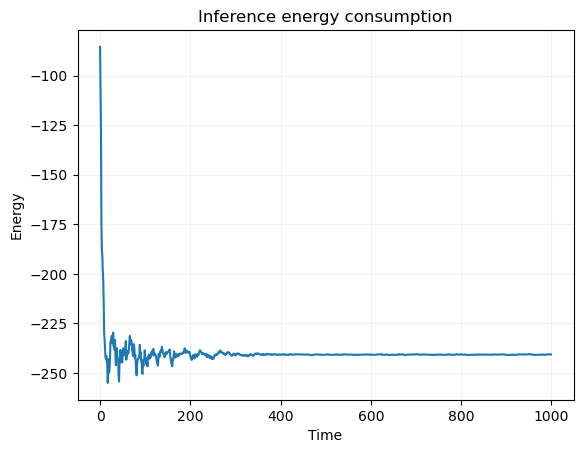

In [1630]:
x = np.arange(len(energy))
y = np.array(energy).squeeze()

plt.figure()
plt.plot(x, y)
plt.grid(axis='both', color='0.95')
plt.title('Inference energy consumption')
plt.xlabel('Time'), plt.ylabel('Energy')